In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

import os.path
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape, ReLU
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, Dropout, Flatten,Input
import time
from keras.utils.vis_utils import plot_model
from keras.datasets.fashion_mnist import load_data
from IPython import display

import glob
import random
import imageio
import PIL, cv2
import pandas as pd
%matplotlib inline
from skimage.morphology import convex_hull_image, erosion
from skimage.morphology import square
import matplotlib.image as mpimg
import skimage
import math
from scipy.ndimage.filters import convolve
from PIL import Image,ImageFilter
from skimage.feature import hessian_matrix, hessian_matrix_eigvals

<ipython-input-2-8b863c13f0ab>:26: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


In [3]:
!pip install kaggle

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/ 

! chmod 600 ~/.kaggle/kaggle.json

!pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! kaggle datasets download ruizgara/socofing

! unzip socofing.zip

In [7]:
# Define paths to original and generated image folders
orig_folder = '/content/drive/MyDrive/Socofing_png' #BMP images
gen_folder = '/content/drive/MyDrive/generated_fingerprints' # sono salvate come jpg ma sono png images

In [ ]:
!pip install fingerflow

In [9]:
import fingerflow 
import os

In [10]:
from fingerflow.extractor import Extractor

extractor = Extractor('/content/drive/MyDrive/Fingerflow/CoarseNet.h5', '/content/drive/MyDrive/Fingerflow/FineNet.h5', '/content/drive/MyDrive/Fingerflow/ClassifyNet_6_classes.h5', '/content/drive/MyDrive/Fingerflow/CoreNet.weights')


Loading FineNet weights from /content/drive/MyDrive/Fingerflow/FineNet.h5
Loading ClassifyNet weights from /content/drive/MyDrive/Fingerflow/ClassifyNet_6_classes.h5
nms iou: 0.413 score: 0.3
all weights read
Core net weights loaded from /content/drive/MyDrive/Fingerflow/CoreNet.weights


In [11]:
def extract_minutiae(image_path):
    image = cv2.imread(image_path)
    minutiae = extractor.extract_minutiae(image)
    return minutiae

In [12]:
tot_orig_minutiae = []
tot_gen_minutiae = []


def analyze_realism(orig_folder, gen_folder):
    
    for filename in os.listdir(orig_folder)[:50]:
        if filename.endswith('.png'):
            image_path = os.path.join(orig_folder, filename)
            minutiae = extract_minutiae(image_path)
            tot_orig_minutiae.append(minutiae)
    
    for filename in os.listdir(gen_folder)[:50]:
        if filename.endswith('.jpg'): #anche questi sono png, ma sono un idiota e confondendoi gli o salvati appendendo il nome sbagliato (si può scambiare).
            image_path = os.path.join(gen_folder, filename)
            minutiae = extract_minutiae(image_path)
            tot_gen_minutiae.append(minutiae)
    
    orig_count = len(tot_orig_minutiae)
    gen_count = len(tot_gen_minutiae)
    
    if orig_count == 0:
        return "No original images found"
    elif gen_count == 0:
        return "No generated images found"


In [ ]:
analyze_realism(orig_folder, gen_folder)

In [14]:
# Initialize counts to zero
core_count = 0
minutiae_count = 0

# Loop over each image dictionary and count non-empty rows in core and minutiae DataFrames
for orig_minutiae in tot_orig_minutiae:
    core_count += orig_minutiae['core'].fillna('').shape[0]
    minutiae_count += orig_minutiae['minutiae'].fillna('').shape[0]

# Count the total number of non-empty rows across all images
total_count = core_count + minutiae_count

# Print the total count
print("Total count: ", total_count)

Total count:  238


In [15]:
# Loop over each image dictionary and count non-empty rows in core and minutiae DataFrames
for gen_minutiae in tot_gen_minutiae:
    core_count += gen_minutiae['core'].fillna('').shape[0]
    minutiae_count += gen_minutiae['minutiae'].fillna('').shape[0]

# Count the total number of non-empty rows across all images
total_count = core_count + minutiae_count

# Print the total count
print("Total count: ", total_count)

Total count:  449


In [18]:
tot_orig_minutiae[:10]

[{'core':    x1  y1  x2   y2     score   w   h
  0  35  70  80  145  0.817767  45  75,
  'minutiae':       x      y     angle     score  class
  0  85.0  141.0  1.429541  0.685174    5.0
  1  85.0  117.0  1.502122  0.523098    3.0
  2  68.0  123.0  1.928388  0.359195    5.0
  3  18.0  149.0  0.618574  0.338394    2.0
  4  66.0  107.0  0.521208  0.191884    5.0},
 {'core': Empty DataFrame
  Columns: [x1, y1, x2, y2, score, w, h]
  Index: [], 'minutiae':        x      y     angle     score  class
  0  129.0   92.0  0.399947  0.989308    4.0
  1  106.0  115.0  3.325754  0.805292    1.0
  2  157.0   82.0  3.616724  0.732606    5.0
  3  114.0  130.0  3.349850  0.710402    5.0
  4   93.0   90.0  0.229823  0.869311    1.0
  5   26.0  141.0  0.709434  0.647843    2.0
  6  163.0  147.0  0.289327  0.578729    5.0
  7   90.0  107.0  0.269931  0.461359    0.0
  8  114.0   67.0  3.421857  0.577457    5.0},
 {'core':    x1  y1   x2   y2    score   w   h
  0  74  92  109  168  0.93365  35  76,
  'min

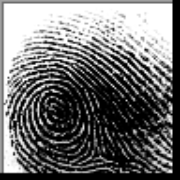

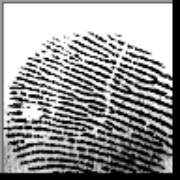

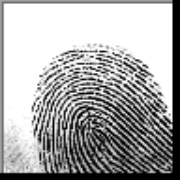

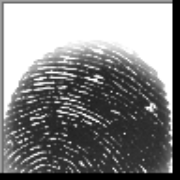

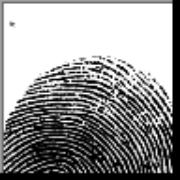

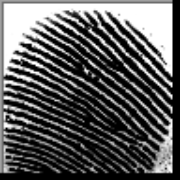

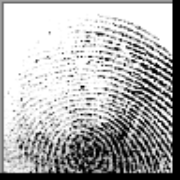

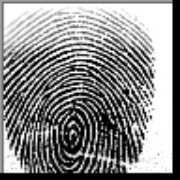

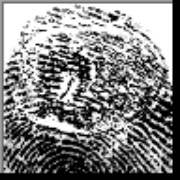

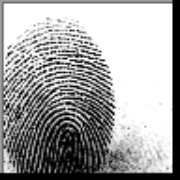

In [24]:
from google.colab.patches import cv2_imshow

for filename in os.listdir(orig_folder)[:10]:
        if filename.endswith('.png'):
            image_path = os.path.join(orig_folder, filename)
            image = cv2.imread(image_path)
            image = cv2_imshow(image)